### Testing for Co-regression with co-training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
from multiview.cotraining.ctregressor import CTRegressor

### 2D Mexican Hat

In [16]:
ups = 100
ni = 100

N_samples = 3750
N_test = 1250
labeled_portion = .1
iter_errors_train_full = []
iter_errors_test_full = []

for seed in range(20):
    np.random.seed(seed)
    X = np.random.uniform(-2*np.pi, 2*np.pi, size=(N_samples,1))
    y = ((np.sin(np.abs(X)))/np.abs(X)).squeeze()
    X_test = np.random.uniform(-2*np.pi, 2*np.pi, size=(N_test,1))
    y_test = ((np.sin(np.abs(X_test)))/np.abs(X_test)).squeeze()

    y_train = y.copy()
    np.random.seed(1) # 0: bad
    selector = np.random.uniform(size=(N_samples,))
    selector[selector > labeled_portion] = np.nan
    y_train[np.isnan(selector)] = np.nan
    lab_samples = ~np.isnan(y_train)

#     ctr = CTRegressor(k_neighbors=3)
#     iter_errors1, iter_errors2, iter_errors = ctr.fit([X, X], y_train, [X[lab_samples], X[lab_samples]], y_train[lab_samples], unlabeled_pool_size=ups, num_iter=ni)
#     iter_errors_train_full.append(iter_errors)
    
    ctr = CTRegressor(k_neighbors=3)
    iter_errors1_test, iter_errors2_test, iter_errors_test = ctr.fit([X, X], y_train, [X_test, X_test], y_test, unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_test_full.append(iter_errors_test)

# iter_errors_train_avg = np.mean(np.array(iter_errors_train_full), axis=0)
iter_errors_test_avg = np.mean(np.array(iter_errors_test_full), axis=0)

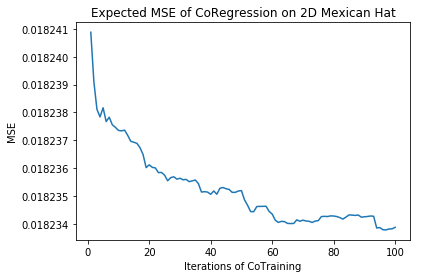

In [17]:
plt.figure()
plt.plot(np.arange(1,ni+1), iter_errors_test_avg)
plt.title("Expected MSE of CoRegression on 2D Mexican Hat")
plt.xlabel("Iterations of CoTraining")
plt.ylabel("MSE")
plt.show()

### 3D Mexican Hat

In [7]:
ups = 100
ni = 100

N_samples = 2250 #3750
N_test = 750
labeled_portion = .1
iter_errors_train_full = []
iter_errors_test_full = []

for seed in range(30):
    np.random.seed(seed)
    X = np.random.uniform(-4*np.pi, 4*np.pi, size=(N_samples,2))
    y = ((np.sin(np.linalg.norm(X, axis=1)))/np.linalg.norm(X, axis=1)).squeeze()
    X_test = np.random.uniform(-4*np.pi, 4*np.pi, size=(N_test,2))
    y_test = ((np.sin(np.linalg.norm(X_test, axis=1)))/np.linalg.norm(X_test, axis=1)).squeeze()

    y_train = y.copy()
    np.random.seed(1)
    selector = np.random.uniform(size=(N_samples,))
    selector[selector > labeled_portion] = np.nan
    y_train[np.isnan(selector)] = np.nan
    lab_samples = ~np.isnan(y_train)

#     ctr = CTRegressor(k_neighbors=3, random_state=0)
#     iter_errors1, iter_errors2, iter_errors = ctr.fit([X, X], y_train, [X[lab_samples], X[lab_samples]], y_train[lab_samples], unlabeled_pool_size=ups, num_iter=ni)
#     iter_errors_train_full.append(iter_errors)
    
    ctr = CTRegressor(k_neighbors=3, random_state=0)
    iter_errors1_test, iter_errors2_test, iter_errors_test = ctr.fit([X, X], y_train, [X_test, X_test], y_test, unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_test_full.append(iter_errors_test)

# iter_errors_train_avg = np.mean(np.array(iter_errors_train_full), axis=0)
iter_errors_test_avg = np.mean(np.array(iter_errors_test_full), axis=0)

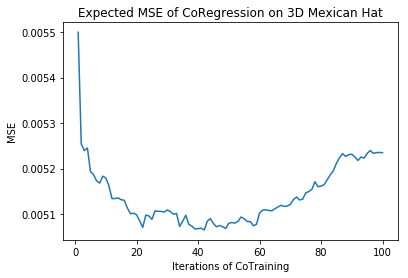

In [8]:
plt.figure()
plt.plot(np.arange(1,ni+1), iter_errors_test_avg)
plt.title("Expected MSE of CoRegression on 3D Mexican Hat")
plt.xlabel("Iterations of CoTraining")
plt.ylabel("MSE")
plt.show()

### Polynomial

In [5]:
ups = 100
ni = 100

N_samples = 2250 #3750
N_test = 750
labeled_portion = .1
iter_errors_train_full = []
iter_errors_test_full = []

for seed in range(30):
    np.random.seed(seed)
    X = np.random.uniform(0, 1, size=(N_samples,1))
    y = (2*X + 3*X**2 + 4*X**3 + 5*X**4 + 1).squeeze()
    X_test = np.random.uniform(0, 1, size=(N_test,1))
    y_test = (2*X_test + 3*X_test**2 + 4*X_test**3 + 5*X_test**4 + 1).squeeze()

    y_train = y.copy()
    np.random.seed(1)
    selector = np.random.uniform(size=(N_samples,))
    selector[selector > labeled_portion] = np.nan
    y_train[np.isnan(selector)] = np.nan
    lab_samples = ~np.isnan(y_train)

#     ctr = CTRegressor(k_neighbors=3, random_state=0)
#     iter_errors1, iter_errors2, iter_errors = ctr.fit([X, X], y_train, [X[lab_samples], X[lab_samples]], y_train[lab_samples], unlabeled_pool_size=ups, num_iter=ni)
#     iter_errors_train_full.append(iter_errors)
    
    ctr = CTRegressor(k_neighbors=3, random_state=0)
    iter_errors1_test, iter_errors2_test, iter_errors_test = ctr.fit([X, X], y_train, [X_test, X_test], y_test, unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_test_full.append(iter_errors_test)

# iter_errors_train_avg = np.mean(np.array(iter_errors_train_full), axis=0)
iter_errors_test_avg = np.mean(np.array(iter_errors_test_full), axis=0)

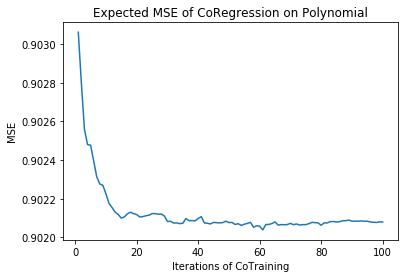

In [6]:
plt.figure()
plt.plot(np.arange(1,ni+1), iter_errors_test_avg)
plt.title("Expected MSE of CoRegression on Polynomial")
plt.xlabel("Iterations of CoTraining")
plt.ylabel("MSE")
plt.show()

## Using Notebook Defined Class

### 2D mexican hat


In [98]:
#### 2D Mexican Hat
# make sure obf is decreasing at each iteration
np.random.seed(6)
N_samples = 3750 #3750
N_test = 1250
labeled_portion = .1

X = np.random.uniform(-2*np.pi, 2*np.pi, size=(N_samples,1))
y = ((np.sin(np.abs(X)))/np.abs(X)).squeeze()
X_test = np.random.uniform(-2*np.pi, 2*np.pi, size=(N_test,1))
y_test = ((np.sin(np.abs(X_test)))/np.abs(X_test)).squeeze()

y_train = y.copy()
np.random.seed(1) # 0: bad
selector = np.random.uniform(size=(N_samples,))
selector[selector > labeled_portion] = np.nan
y_train[np.isnan(selector)] = np.nan
lab_samples = ~np.isnan(y_train)



ups = 100
ni = 100

N_samples = 3750
N_test = 1250
labeled_portion = .1
iter_errors_train_full = []
iter_errors_test_full = []

for seed in range(50):
    np.random.seed(seed)
    X = np.random.uniform(-2*np.pi, 2*np.pi, size=(N_samples,1))
    y = ((np.sin(np.abs(X)))/np.abs(X)).squeeze()
    X_test = np.random.uniform(-2*np.pi, 2*np.pi, size=(N_test,1))
    y_test = ((np.sin(np.abs(X_test)))/np.abs(X_test)).squeeze()

    y_train = y.copy()
    np.random.seed(1) # 0: bad
    selector = np.random.uniform(size=(N_samples,))
    selector[selector > labeled_portion] = np.nan
    y_train[np.isnan(selector)] = np.nan
    lab_samples = ~np.isnan(y_train)

    ctr = CTRegressor(k_neighbors=3, random_state=0, thresh=0)
    iter_errors1, iter_errors2, iter_errors = ctr.fit([X, X], y_train, [X[lab_samples], X[lab_samples]], y_train[lab_samples], unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_train_full.append(iter_errors)
    
    ctr = CTRegressor(k_neighbors=3, random_state=0, thresh=0)
    iter_errors1_test, iter_errors2_test, iter_errors_test = ctr.fit([X, X], y_train, [X_test, X_test], y_test, unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_test_full.append(iter_errors)

iter_errors_train_avg = np.mean(np.array(iter_errors_train_full), axis=0)
iter_errors_test_avg = np.mean(np.array(iter_errors_test_full), axis=0)


### Recreate figure part a
https://www.ijcai.org/Proceedings/05/Papers/0689.pdf

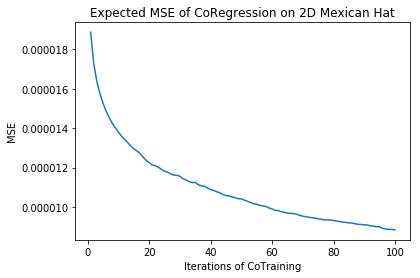

In [99]:
plt.figure()
plt.plot(np.arange(1,ni+1), iter_errors_test_avg)
plt.title("Expected MSE of CoRegression on 2D Mexican Hat")
plt.xlabel("Iterations of CoTraining")
plt.ylabel("MSE")
plt.show()

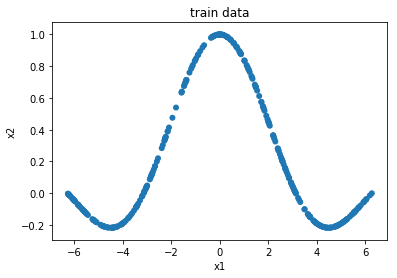

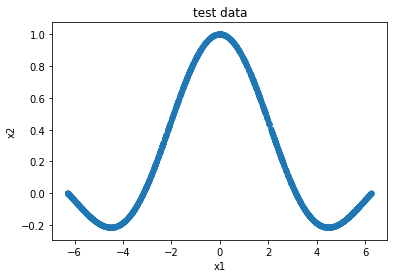

In [90]:
plot_y_train = y_train.copy()
plot_y_test = y_test.copy()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[lab_samples,0], plot_y_train[lab_samples], cmap='cividis', edgecolor='none')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title("train data")
plt.gray()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_test, y_test, cmap='cividis', edgecolor='none')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title("test data")
plt.gray()
plt.show()

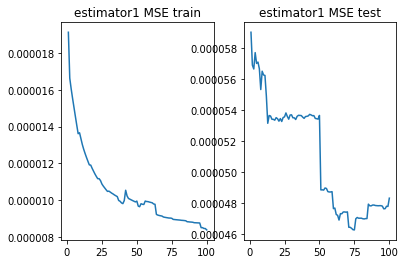

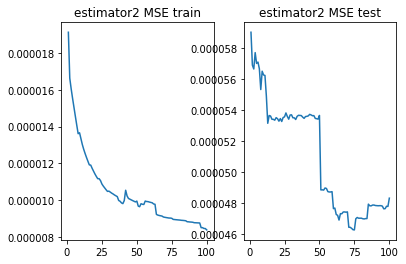

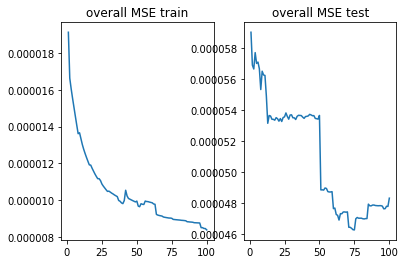

In [89]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors1)
ax1.set_title("estimator1 MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors1_test)
ax2.set_title("estimator1 MSE test")
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors2)
ax1.set_title("estimator2 MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors2_test)
ax2.set_title("estimator2 MSE test")
plt.show()


fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors)
ax1.set_title("overall MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors_test)
ax2.set_title("overall MSE test")
plt.show()


### 3D mexican hat


In [129]:
#### 3D Mexican Hat
# make sure obf is decreasing at each iteration
np.random.seed(6)
N_samples = 2250 #3750
N_test = 750
labeled_portion = .1

X = np.random.uniform(-4*np.pi, 4*np.pi, size=(N_samples,2))
y = ((np.sin(np.linalg.norm(X, axis=1)))/np.linalg.norm(X, axis=1)).squeeze()
X_test = np.random.uniform(-4*np.pi, 4*np.pi, size=(N_test,2))
y_test = ((np.sin(np.linalg.norm(X_test, axis=1)))/np.linalg.norm(X_test, axis=1)).squeeze()

y_train = y.copy()
selector = np.random.uniform(size=(N_samples,))
selector[selector > labeled_portion] = np.nan
y_train[np.isnan(selector)] = np.nan
lab_samples = ~np.isnan(y_train)



ups = 100
ni = 10

N_samples = 2250 #3750
N_test = 750
labeled_portion = .1
iter_errors_train_full = []
iter_errors_test_full = []

for seed in range(1):
    np.random.seed(seed)
    X = np.random.uniform(-4*np.pi, 4*np.pi, size=(N_samples,2))
    y = ((np.sin(np.linalg.norm(X, axis=1)))/np.linalg.norm(X, axis=1)).squeeze()
    X_test = np.random.uniform(-4*np.pi, 4*np.pi, size=(N_test,2))
    y_test = ((np.sin(np.linalg.norm(X_test, axis=1)))/np.linalg.norm(X_test, axis=1)).squeeze()

    y_train = y.copy()
    np.random.seed(1)
    selector = np.random.uniform(size=(N_samples,))
    selector[selector > labeled_portion] = np.nan
    y_train[np.isnan(selector)] = np.nan
    lab_samples = ~np.isnan(y_train)

    ctr = CTRegressor(k_neighbors=3, random_state=0)
    iter_errors1, iter_errors2, iter_errors = ctr.fit([X, X], y_train, [X[lab_samples], X[lab_samples]], y_train[lab_samples], unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_train_full.append(iter_errors)
    
    ctr = CTRegressor(k_neighbors=3, random_state=0)
    iter_errors1_test, iter_errors2_test, iter_errors_test = ctr.fit([X, X], y_train, [X_test, X_test], y_test, unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_test_full.append(iter_errors)

iter_errors_train_avg = np.mean(np.array(iter_errors_train_full), axis=0)
iter_errors_test_avg = np.mean(np.array(iter_errors_test_full), axis=0)


### Recreate figure part b
https://www.ijcai.org/Proceedings/05/Papers/0689.pdf

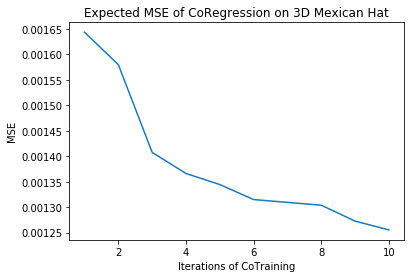

In [130]:
plt.figure()
plt.plot(np.arange(1,ni+1), iter_errors_test_avg)
plt.title("Expected MSE of CoRegression on 3D Mexican Hat")
plt.xlabel("Iterations of CoTraining")
plt.ylabel("MSE")
plt.show()

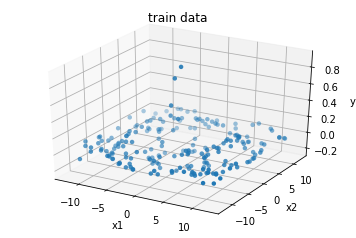

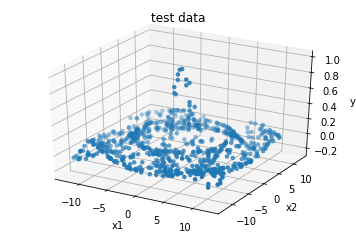

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[lab_samples,0], X[lab_samples,1], y_train[lab_samples], cmap='viridis', edgecolor='none')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title("train data")
plt.gray()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:,0], X_test[:,1], y_test, cmap='viridis', edgecolor='none')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title("test data")
plt.gray()
plt.show()

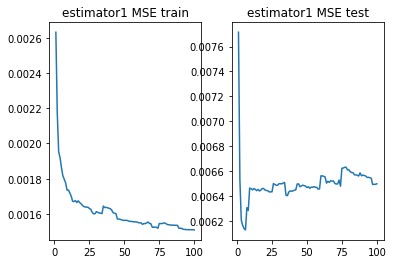

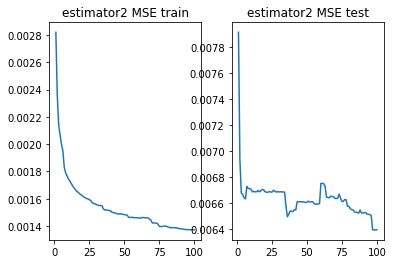

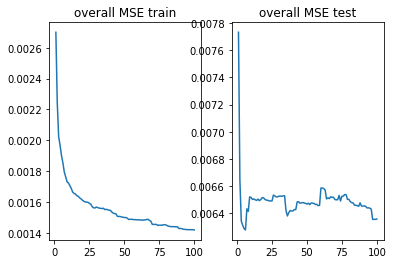

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors1)
ax1.set_title("estimator1 MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors1_test)
ax2.set_title("estimator1 MSE test")
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors2)
ax1.set_title("estimator2 MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors2_test)
ax2.set_title("estimator2 MSE test")
plt.show()


fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors)
ax1.set_title("overall MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors_test)
ax2.set_title("overall MSE test")
plt.show()


### Polynomial

In [9]:
#### Polynomial
# make sure obf is decreasing at each iteration

ups = 100
ni = 100

N_samples = 2250 #3750
N_test = 750
labeled_portion = .1
iter_errors_train_full = []
iter_errors_test_full = []

for seed in range(10):
    np.random.seed(seed)
    X = np.random.uniform(0, 1, size=(N_samples,1))
    y = (2*X + 3*X**2 + 4*X**3 + 5*X**4 + 1).squeeze()
    X_test = np.random.uniform(0, 1, size=(N_test,1))
    y_test = (2*X_test + 3*X_test**2 + 4*X_test**3 + 5*X_test**4 + 1).squeeze()

    y_train = y.copy()
    np.random.seed(1)
    selector = np.random.uniform(size=(N_samples,))
    selector[selector > labeled_portion] = np.nan
    y_train[np.isnan(selector)] = np.nan
    lab_samples = ~np.isnan(y_train)

    ctr = CTRegressor(k_neighbors=3, random_state=0)
    iter_errors1, iter_errors2, iter_errors = ctr.fit([X, X], y_train, [X[lab_samples], X[lab_samples]], y_train[lab_samples], unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_train_full.append(iter_errors)
    
    ctr = CTRegressor(k_neighbors=3, random_state=0)
    iter_errors1_test, iter_errors2_test, iter_errors_test = ctr.fit([X, X], y_train, [X_test, X_test], y_test, unlabeled_pool_size=ups, num_iter=ni)
    iter_errors_test_full.append(iter_errors)

iter_errors_train_avg = np.mean(np.array(iter_errors_train_full), axis=0)
iter_errors_test_avg = np.mean(np.array(iter_errors_test_full), axis=0)


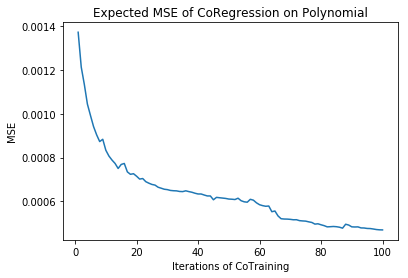

In [12]:
plt.figure()
plt.plot(np.arange(1,ni+1), iter_errors_test_avg)
plt.title("Expected MSE of CoRegression on Polynomial")
plt.xlabel("Iterations of CoTraining")
plt.ylabel("MSE")
plt.show()

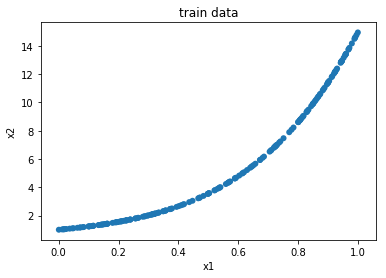

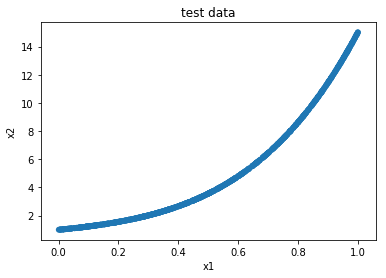

In [7]:
plot_y_train = y_train.copy()
plot_y_test = y_test.copy()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[lab_samples,0], plot_y_train[lab_samples], cmap='cividis', edgecolor='none')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title("train data")
plt.gray()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_test, y_test, cmap='cividis', edgecolor='none')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title("test data")
plt.gray()
plt.show()

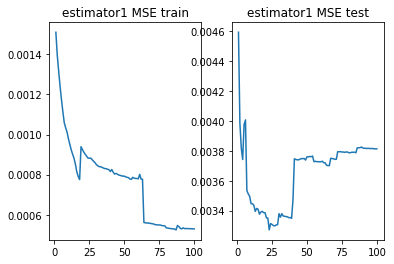

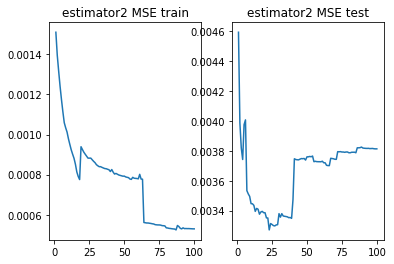

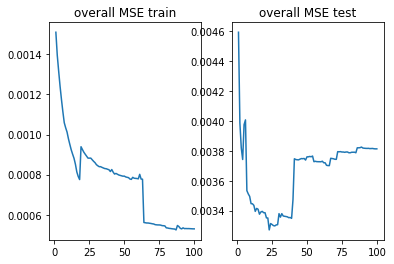

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors1)
ax1.set_title("estimator1 MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors1_test)
ax2.set_title("estimator1 MSE test")
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors2)
ax1.set_title("estimator2 MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors2_test)
ax2.set_title("estimator2 MSE test")
plt.show()


fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(1,len(iter_errors)+1), iter_errors)
ax1.set_title("overall MSE train")
ax2.plot(np.arange(1,len(iter_errors_test)+1), iter_errors_test)
ax2.set_title("overall MSE test")
plt.show()

### CTRegressor Class

In [2]:
class CTRegressor():
    def __init__(
                 self,
                 k_neighbors=3,
                 p=[2, 5],
                 regressor_weights=[.5, .5],
                 random_state=0
                 ):
        """
        Co-Training Regressor
        This class implements the co-training regressor with the framework as
        described in [1]. This should ideally be used on 2 views of the input
        data which satisfy the 3 conditions for multi-view co-training
        (sufficiency, compatibility, conditional independence) as detailed in [2].
        Extends BaseCoTrainEstimator.
        
        Parameters
        ----------
        k_neighbors : int
            The number of neighbors for KNeighborsRegressor estimators and for
            estimating the change in MSE of unlabeled samples.
        p : List of int, length = n_views
            Distance orders used for KNeighborsRegressors.
        regressor_weights : List of real numbers, length = n_views, default [.5, .5]
            The weights to assign to each view's regressor's estimates when
            computing the fully regression predictions. Final predictions are
            computed as regressor_weights[0] * estimator1_predictions +
            regressor_weights[1] * estimator2_predictions.
        random_state : int
            The starting random seed for fit() and other class operations.

        Attributes
        ----------
        estimator1 : sklearn KNeighborsRegressor object
            The regressor used on view 1.
        estimator2 : sklearn KNeighborsRegressor object
            The regressor used on view 2.
        class_name: string
            The name of the class.
        n_views_ : int
            The number of views supported by the multi-view classifier
        p_ : List of int, length = n_views
            Distance orders used for KNeighborsRegressors.
        num_iter_ : int
            Maximum number of training iterations to run.
        regressor_weights_ : List of real numbers, length = n_views, default [.5, .5]
            The weights to assign to each view's regressor's estimates when
            computing the fully regression predictions. Final predictions are
            computed as regressor_weights[0] * estimator1_predictions +
            regressor_weights[1] * estimator2_predictions.
        random_state : int
            The starting random seed for fit() and other class operations.
            
        References
        ----------
        [1] Zhou, Z. H., & Li, M. (2005, July). Semi-Supervised Regression
        with Co-Training. In IJCAI (Vol. 5, pp. 908-913).
        
        [2] Blum, A., & Mitchell, T. (1998, July). Combining labeled and
        unlabeled_pool data with co-training. In Proceedings of the eleventh
        annual conference on Computational learning theory (pp. 92-100). ACM.
        """

        # initialize a BaseCTEstimator object
        #super().__init__(KNeighborsRegressor(n_neighbors=k_neighbors), KNeighborsRegressor(n_neighbors=k_neighbors), random_state)
        self.random_state = random_state

        self.p_ = []
        self.estimator1 = KNeighborsRegressor(n_neighbors=k_neighbors, p=p[0])
        self.p_.append(p[0])
        self.estimator2 = KNeighborsRegressor(n_neighbors=k_neighbors, p=p[1])
        self.p_.append(p[1])

        self.n_views_ = 2  # only 2 view learning supported currently

        self.class_name = "CTRegressor"
        
        self.k_neighbors_ = k_neighbors
        
        self.regressor_weights_ = regressor_weights


    # requires Labeled sets for each view, U' shared by both views
    def fit(
            self,
            Xs,
            y,
            X_test,
            y_test,
            unlabeled_pool_size=75,
            num_iter=50,
            ):
        """
        Fit the regressor object to the data in Xs, y.
        
        Parameters
        ----------
        Xs : list of array-likes
            - Xs shape: (n_views,)
            - Xs[i] shape: (n_samples, n_features_i)
            A list of the different views of data to train on.
        y : array, shape (n_samples,)
            The labels of the training data. Unlabeled_pool examples should
            have label np.nan.
        unlabeled_pool_size : int, optional (default=75)
            The number of unlabeled_pool samples which will be kept in a
            separate pool for classification and selection by the updated
            classifier at each training iteration.
        num_iter : int, optional (default=50)
            The maximum number of training iterations to run.
        """

        y = np.array(y)
        y = y.reshape(-1,)
                
        np.random.seed(self.random_state)
        
        self.unlabeled_pool_size_ = unlabeled_pool_size
        self.num_iter_ = num_iter

        # extract the multiple views given
        X1 = Xs[0]
        X2 = Xs[1]

        # the full set of unlabeled samples
        U = [i for i, y_i in enumerate(y) if np.isnan(y_i)]

        # shuffle unlabeled_pool data for easy random access
        np.random.shuffle(U)

        # the small pool of unlabled samples to draw from in training
        unlabeled_pool = U[-min(len(U), self.unlabeled_pool_size_):]

        # the labeled samples
        L = [i for i, y_i in enumerate(y) if ~np.isnan(y_i)]

        # remove the pool from overall unlabeled data
        U = U[:-len(unlabeled_pool)]

        it = 0
        
        iter_errors = []
        iter_errors1 = []
        iter_errors2 = []
        
        while it < self.num_iter_ and U:
            it += 1

            # fit each model to its respective view
            self.estimator1.fit(X1[L], y[L])
            self.estimator2.fit(X2[L], y[L])
            
            if X_test is not None:
                y_hat_test = self.predict(X_test)
                iter_errors.append(((np.linalg.norm(y_hat_test - y_test))**2)/X_test[0].shape[0])
                y_hat_test1 = self.estimator1.predict(X_test[0])
                iter_errors1.append(((np.linalg.norm(y_hat_test1 - y_test))**2)/X_test[0].shape[0])
                y_hat_test2 = self.estimator2.predict(X_test[1])
                iter_errors2.append(((np.linalg.norm(y_hat_test2 - y_test))**2)/X_test[0].shape[0])
            
            y_hat1 = self.estimator1.predict(X1[unlabeled_pool])
            y_hat2 = self.estimator2.predict(X2[unlabeled_pool])
            
            neighbors1 = (self.estimator1.kneighbors(X1[unlabeled_pool], n_neighbors=self.k_neighbors_))[1]
            neighbors2 = (self.estimator1.kneighbors(X2[unlabeled_pool], n_neighbors=self.k_neighbors_))[1]
            
            # find sample in each view which lowers the MSE the most
            delta_MSE1 = []
            for sample, (u, neigh) in enumerate(zip(unlabeled_pool, neighbors1)):
                new_L = L.copy()
                new_L.append(u)
                new_y = np.concatenate((y[L].copy(), np.array(y_hat1[sample]).reshape(1,)))
                new_estimator = KNeighborsRegressor(n_neighbors=self.k_neighbors_, p=self.p_[0])
                new_estimator.fit(X1[new_L], new_y)
                delta_MSE1.append(self.estimate_delta_MSE_(self.estimator1, new_estimator, (X1[L])[neigh], (y[L])[neigh]))
            
            best_delta_idx = np.argmin(delta_MSE1)
            now_labeled = []
            add_labels = []
            if delta_MSE1[best_delta_idx] > 0:
                now_labeled.append(unlabeled_pool[best_delta_idx])
                add_labels.append(y_hat1[best_delta_idx])
            
            delta_MSE2 = []
            for sample, (u, neigh) in enumerate(zip(unlabeled_pool, neighbors2)):
                new_L = L.copy()
                new_L.append(u)
                new_y = np.concatenate((y[L].copy(), np.array(y_hat2[sample]).reshape(1,)))
                new_estimator = KNeighborsRegressor(n_neighbors=self.k_neighbors_, p=self.p_[1])
                new_estimator.fit(X2[new_L], new_y)
                delta_MSE2.append(self.estimate_delta_MSE_(self.estimator2, new_estimator, (X2[L])[neigh], (y[L])[neigh])) 
            
            # find top 2 in case overlap with view 1 selection
            best_delta_idx = np.argsort(delta_MSE2)[-2:][::-1]
            if delta_MSE2[best_delta_idx[0]] > 0 and unlabeled_pool[best_delta_idx[0]] not in now_labeled:
                now_labeled.append(unlabeled_pool[best_delta_idx[0]])
                add_labels.append(y_hat1[best_delta_idx[0]])
            elif delta_MSE2[best_delta_idx[1]] > 0:
                now_labeled.append(unlabeled_pool[best_delta_idx[1]])
                add_labels.append(y_hat1[best_delta_idx[1]])
                    
            # create new labels for new additions to the labeled group
            for x, y_hat in zip(now_labeled, add_labels):
                y[x] = y_hat
                #L.extend([x])
                L.append(x)


            # remove newly labeled samples from unlabeled_pool
            unlabeled_pool = [elem for elem in unlabeled_pool
                              if not (elem in now_labeled)]

            # add new elements to unlabeled_pool
            add_counter = 0
            while add_counter != len(now_labeled) and U:
                add_counter += 1
                unlabeled_pool.append(U.pop())

        # fit the overall model on fully "labeled" data
        self.estimator1.fit(X1[L], y[L])
        self.estimator2.fit(X2[L], y[L])
        
        return iter_errors1, iter_errors2, iter_errors
            
    def estimate_delta_MSE_(self, old_estimator, new_estimator, X, y):
        """
        Estimate the decrease in MSE of the new estimator based on a small
        sample of neighbors.
        
        Parameters
        ----------
        old_estimator: estimator object
            The current estimator trained on less data.
        
        new_estimator: estimator object
            The new estimator trained with additional data.
            
        X : array-like, shape (n_samples, n_features)
            The truly labeled data that the old estimator was trained on.
        
        y : array-like, shape (n_samples,)
            The labels for the samples in X.
        
        Returns
        -------
        delta_MSE : float
            
        
        """
        
        # estimate the change in MSE
        y_hat_old = old_estimator.predict(X)
        y_hat_new = new_estimator.predict(X)
        
#         print("errors")
#         print(np.sum((y-y_hat_old)**2))
#         print(np.sum((y-y_hat_new)**2))
        
        return (np.sum((y-y_hat_old)**2 - (y-y_hat_new)**2))/X[0].shape[0]
            
    def predict(self, Xs):
        """
        Predict the regression output of the examples in the two input views.
        
        Parameters
        ----------
        Xs : list of array-likes
            - Xs shape: (n_views,)
            - Xs[i] shape: (n_samples, n_features_i)
            A list of the different views of data to predict.
            
        Returns
        -------
        y : array-like (n_samples,)
            The estimated values.
        """

#         Xs = check_Xs(Xs,
#                       multiview=True,
#                       enforce_views=self.n_views_)
        
        return self.regressor_weights_[0] * self.estimator1.predict(Xs[0]) + self.regressor_weights_[1] * self.estimator2.predict(Xs[1])
    

In [65]:
xx = [-1,3,-2,5]
print(np.argsort(xx)[-2:][::-1])
xx = np.array([[0,1,2], [1,2,3]])
print(xx.shape)
for samp in xx:
    print(samp)
    
y = np.zeros(10,)
y2 = np.ones(10,)
print(type(np.sum((y-y2)**2)))

[3 1]
(2, 3)
[0 1 2]
[1 2 3]
<class 'numpy.float64'>
